### DTI data processing
We thank Adam Bernstein for producing this notebook and sharing his DWI data!!

In [1]:
# Load in relevant Libraries
push!(LOAD_PATH,"library")
using Read_NIfTI1_real
using PyPlot
using NK_tools

In [2]:
# Load in Diffusion Weighted Images and diffusion weighting information
# DWI
filename = "/xdisk/nkchen/dataDWI/dwi.nii.gz";
headerinfo = load_niigz_header(filename);
dwi = load_niigz_data(filename, headerinfo);

# Brain Mask
filename = "/xdisk/nkchen/dataDWI/mask.nii.gz"
headerinfo = load_niigz_header(filename);
mask = load_niigz_data(filename, headerinfo);

# b-vectors
bvecs = readdlm("/xdisk/nkchen/dataDWI/bvec");

# b-values
bvals = readdlm("/xdisk/nkchen/dataDWI/bval");

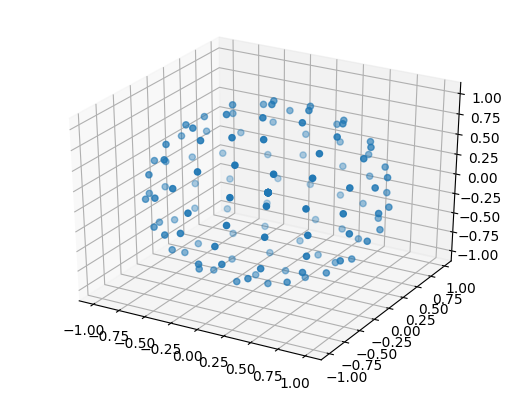

In [3]:
# Display diffusion directions measured
scatter3D(bvecs[1,:], bvecs[2,:], bvecs[3,:]);

In [4]:
# Construct a 'B-Matrix' for linear fitting based on b-values and bvectors
b_mat = ones(size(dwi)[4],7)
b_mat[:,2] = bvecs[1,:] .^ 2;
b_mat[:,3] = bvecs[2,:] .^ 2;
b_mat[:,4] = bvecs[3,:] .^ 2;
b_mat[:,5] = 2 * bvecs[1,:] .* bvecs[2,:];
b_mat[:,6] = 2 * bvecs[1,:] .* bvecs[3,:];
b_mat[:,7] = 2 * bvecs[2,:] .* bvecs[3,:];

for i = 2:7
    b_mat[:,i] = b_mat[:,i] .* -bvals'
end

# First column of b-matrix is all ones, which is used to fit the b=0 value, especially important when we have multiple b=0 images

In [5]:
# Perform Linear fit for each voxel
eigen_values = zeros(size(dwi)[1], size(dwi)[2], size(dwi)[3], 3);
Tensor = zeros(3,3)
dwi = log.(dwi)
for i = 1:size(dwi)[1]
    for j = 1:size(dwi)[2]
        for k = 1:size(dwi)[3]
            if mask[i,j,k] != 0
                D = b_mat \ dwi[i,j,k,:];
                Tensor[1,1] = D[2];
                Tensor[1,2] = D[5];
                Tensor[1,3] = D[6];
                Tensor[2,1] = D[5];
                Tensor[2,2] = D[3];
                Tensor[2,3] = D[7];
                Tensor[3,1] = D[6];
                Tensor[3,2] = D[7];
                Tensor[3,3] = D[4];

                # Diagonalize Tensor to get EigenValues
                eigen_values[i,j,k,:] = eigvals(Tensor);
            end
        end
    end
end  

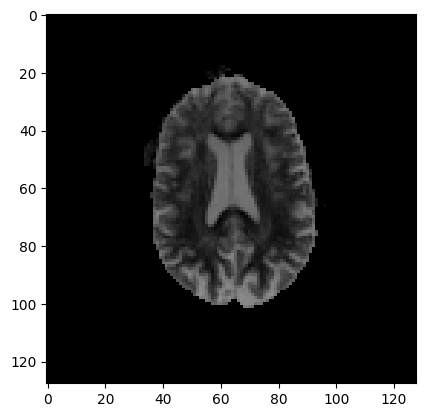

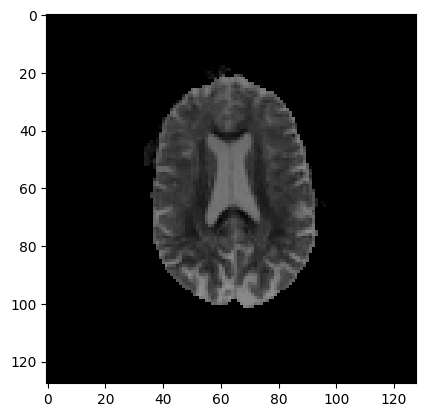

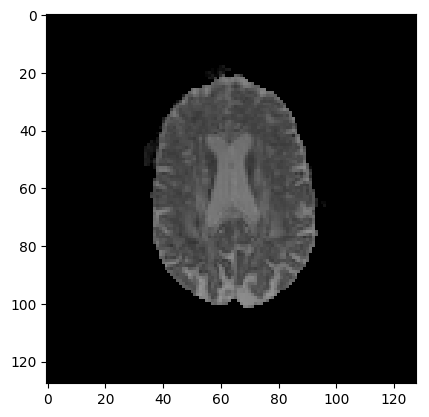

In [6]:
# Display EigenValue Images
figure(1)
imshow(flipdim(permutedims(eigen_values[:,:,37,1],[2 1]),1),cmap="gray", vmin=0, vmax=0.002);
figure(2)
imshow(flipdim(permutedims(eigen_values[:,:,37,2],[2 1]),1),cmap="gray", vmin=0, vmax=0.002);
figure(3)
imshow(flipdim(permutedims(eigen_values[:,:,37,3],[2 1]),1),cmap="gray", vmin=0, vmax=0.002);

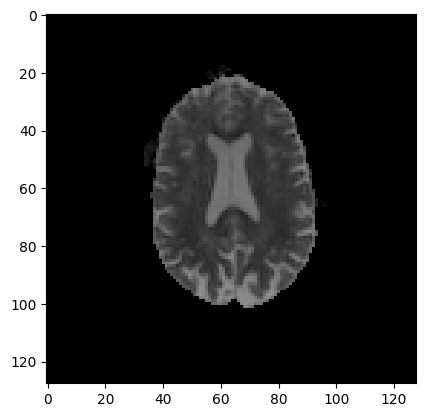

In [7]:
# Calulate MD
MD = mean(eigen_values, 4);
imshow(flipdim(permutedims(MD[:,:,37],[2 1]),1), cmap="gray", vmin=0, vmax=0.002);

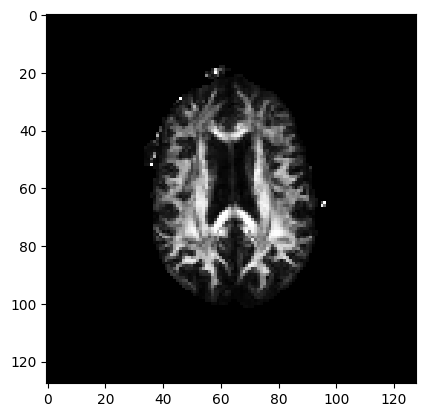

In [8]:
# Calulate FA
numerator = sqrt.((eigen_values[:,:,:,1] - eigen_values[:,:,:,2]) .^ 2 + (eigen_values[:,:,:,2] - eigen_values[:,:,:,3]) .^ 2 + (eigen_values[:,:,:,3] - eigen_values[:,:,:,1]) .^ 2);
denominator = sqrt.(eigen_values[:,:,:,1] .^ 2 + eigen_values[:,:,:,2] .^ 2 + eigen_values[:,:,:,3] .^ 2);

FA = sqrt.(0.5) * numerator ./ denominator;
FA[isnan.(FA)] = 0;
imshow(flipdim(permutedims(FA[:,:,37],[2 1]),1), cmap="gray", vmin=0, vmax=1);